Unzipping the uploaded files

In [ ]:
import zipfile
import os

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
zip_files = {
    "Test_A": "/content/testA.zip",  # Adjust the file name if different
    "Train_A": "/content/trainA.zip",
    "Test_B": "/content/testB.zip",
    "Train_B": "/content/trainB.zip"
}

def unzip_file(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_file_path} to {extract_to}")

# Unzip each file
unzip_file(zip_files["Test_A"], "/content/test_a")
unzip_file(zip_files["Train_A"], "/content/train_a")
unzip_file(zip_files["Test_B"], "/content/test_b")
unzip_file(zip_files["Train_B"], "/content/train_b")

Extracted /content/testA.zip to /content/test_a
Extracted /content/trainA.zip to /content/train_a
Extracted /content/testB.zip to /content/test_b
Extracted /content/trainB.zip to /content/train_b


In [ ]:
# Verify the contents of the unzipped folders
print("Contents of TEST_A:", os.listdir("/content/test_a"))
print("Contents of TRAIN_A:", os.listdir("/content/train_a"))
print("Contents of TEST_B:", os.listdir("/content/test_b"))
print("Contents of TRAIN_B:", os.listdir("/content/train_b"))


Contents of TEST_A: ['testA']
Contents of TRAIN_A: ['trainA']
Contents of TEST_B: ['testB']
Contents of TRAIN_B: ['trainB']


1. Loading dataset using pytorch

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Defining image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the images to 128x128 pixels
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

In [ ]:
# Loading datasets
train_dataset_A = datasets.ImageFolder('/content/train_a', transform=transform)
test_dataset_A = datasets.ImageFolder('/content/test_a', transform=transform)


In [ ]:
# Creating data loaders for batching
train_loader_A = DataLoader(train_dataset_A, batch_size=32, shuffle=True)
test_loader_A = DataLoader(test_dataset_A, batch_size=32, shuffle=False)

In [ ]:
# Checking the number of classes in the dataset ( corresponds to subfolders)
num_classes = len(train_dataset_A.classes)
print(f"Number of classes: {num_classes}")
print(f"Class names: {train_dataset_A.classes}")

Number of classes: 1
Class names: ['trainA']


In [ ]:
# Checking one batch of data
data_iter = iter(train_loader_A)
images, labels = next(data_iter)  # Use the `next()` function
print(f"Batch shape: {images.shape}, Labels: {labels}")


Batch shape: torch.Size([32, 3, 128, 128]), Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


All labels in this batch are 0, meaning that all 32 images in this batch belong to the same class (class 0).



2. Creating a Cycle GAN

In [ ]:
# Defining the generator architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # You can modify this simple architecture
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
# Defining the discriminator architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
# Initializing models

G_A2B = Generator().cuda()
G_B2A = Generator().cuda()
D_A = Discriminator().cuda()
D_B = Discriminator().cuda()


Loss Functions and Optimizers

In [ ]:
# Loss functions
criterion_GAN = nn.MSELoss()  # Adversarial loss
criterion_cycle = nn.L1Loss()  # Cycle consistency loss
criterion_identity = nn.L1Loss()  # Identity loss

In [ ]:
# Optimizers for both generators and discriminators
optimizer_G = optim.Adam(list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))



In [ ]:
# Set the models to training mode
G_A2B.train()
G_B2A.train()
D_A.train()
D_B.train()


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): Sigmoid()
  )
)

Training

In [ ]:
# Training parameters
epochs = 50
lambda_cycle = 10.0  # Cycle consistency weight
lambda_identity = 5.0  # Identity loss weight

In [ ]:
for epoch in range(epochs):
    for i, (real_A, _) in enumerate(train_loader_A):

        # Move data to GPU
        real_A = real_A.cuda()

        # Train Generators G_A2B and G_B2A
        optimizer_G.zero_grad()

        # Identity loss (G_A2B should translate A to A and G_B2A should translate B to B)
        loss_id_A = criterion_identity(G_B2A(real_A), real_A) * lambda_identity

        # GAN loss
        fake_B = G_A2B(real_A)
        pred_fake = D_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, torch.ones_like(pred_fake).cuda())

        # Cycle loss
        rec_A = G_B2A(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A) * lambda_cycle

        # Total loss for generators
        loss_G = loss_id_A + loss_GAN_A2B + loss_cycle_A
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminators D_A and D_B
        optimizer_D_A.zero_grad()

        pred_real = D_A(real_A)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real).cuda())

        pred_fake = D_A(rec_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake).cuda())

        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        print(f"Epoch [{epoch}/{epochs}], Batch [{i}], Loss G: {loss_G.item()}, Loss D_A: {loss_D_A.item()}")

Epoch [0/50], Batch [0], Loss G: 9.393075942993164, Loss D_A: 0.2599491477012634
Epoch [0/50], Batch [1], Loss G: 8.113542556762695, Loss D_A: 0.2602437734603882
Epoch [0/50], Batch [2], Loss G: 7.110549449920654, Loss D_A: 0.2415747344493866
Epoch [0/50], Batch [3], Loss G: 5.874603748321533, Loss D_A: 0.23278622329235077
Epoch [0/50], Batch [4], Loss G: 5.406147003173828, Loss D_A: 0.22408628463745117
Epoch [0/50], Batch [5], Loss G: 4.781951904296875, Loss D_A: 0.21349012851715088
Epoch [0/50], Batch [6], Loss G: 4.572748184204102, Loss D_A: 0.20556488633155823
Epoch [0/50], Batch [7], Loss G: 4.267312049865723, Loss D_A: 0.20309403538703918
Epoch [0/50], Batch [8], Loss G: 4.071655750274658, Loss D_A: 0.22644250094890594
Epoch [0/50], Batch [9], Loss G: 3.95011830329895, Loss D_A: 0.2154073417186737
Epoch [0/50], Batch [10], Loss G: 4.156464576721191, Loss D_A: 0.20442059636116028
Epoch [0/50], Batch [11], Loss G: 3.6364591121673584, Loss D_A: 0.19430899620056152
Epoch [0/50], Batc

3. Show your results ( Few converted images).

In [ ]:
def imshow(tensor, ax, title=None):
    image = tensor.cpu().clone().detach()  # Detach the tensor from computation graph
    image = image.numpy().transpose(1, 2, 0)  # Change shape to (H, W, C)
    image = (image + 1) / 2  # Undo normalization (-1, 1) -> (0, 1)
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')

In [ ]:
def show_converted_images(G_A2B, G_B2A, data_loader):
    G_A2B.eval()  # Set generator to evaluation mode
    G_B2A.eval()

    # Get a batch of images from the dataset
    real_A, _ = next(iter(data_loader))
    real_A = real_A.cuda()  # Move to GPU

    # Generate fake images
    fake_B = G_A2B(real_A)
    rec_A = G_B2A(fake_B)

    # Convert tensors to images and display
    fig, axes = plt.subplots(3, 6, figsize=(12, 6))

    for i in range(6):  # Show 6 images
        # Original A
        imshow(real_A[i], axes[0, i], title="Real A")
        # Translated to B (Fake B)
        imshow(fake_B[i], axes[1, i], title="Fake B")
        # Reconstructed A (cycle consistency)
        imshow(rec_A[i], axes[2, i], title="Rec A")

    plt.tight_layout()
    plt.show()

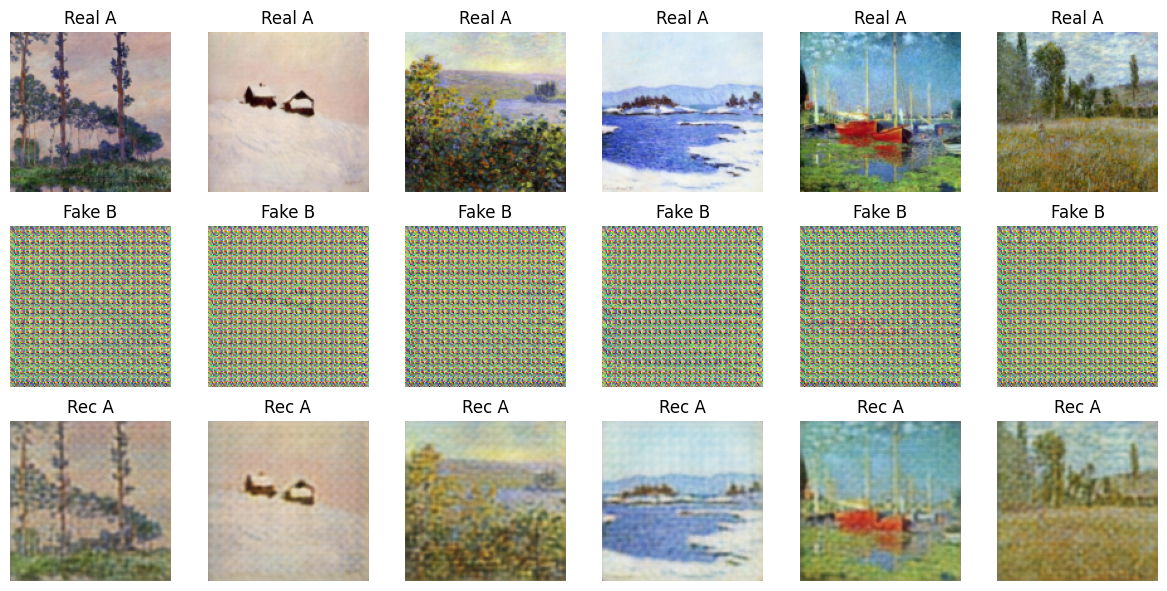

In [ ]:
# Example usage
show_converted_images(G_A2B, G_B2A, train_loader_A)

Real A: These images look good and correspond to the original images from domain A.


Fake B: These images seem to have a repetitive pattern or noise instead of meaningful generated images. This indicates that the generator G_A2B is not properly learning to translate images from domain A to domain B.


Rec A: These images seem blurry but somewhat resemble the original images, which means that the cycle-consistency loss is working to some extent but not fully recovering the original details.

To improve fake images either more training or adjusting the loss func and dec the learning rates

In [ ]:
import torch

# Define paths where you want to save the models
path_G_A2B = "/content/G_A2B.pth"
path_G_B2A = "/content/G_B2A.pth"
path_D_A = "/content/D_A.pth"
path_D_B = "/content/D_B.pth"

# Save the models
torch.save(G_A2B.state_dict(), path_G_A2B)
torch.save(G_B2A.state_dict(), path_G_B2A)
torch.save(D_A.state_dict(), path_D_A)
torch.save(D_B.state_dict(), path_D_B)

print("Models saved successfully!")


Models saved successfully!


In [ ]:
from google.colab import files

# Download the saved models to your local machine
files.download(path_G_A2B)
files.download(path_G_B2A)
files.download(path_D_A)
files.download(path_D_B)

print("Models downloaded successfully!")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Models downloaded successfully!


Tunning for better result


In [ ]:
# Training parameters
epochs = 100  # Increase number of epochs
lambda_cycle = 20.0  # Increase cycle-consistency loss weight
lambda_identity = 5.0  # Identity loss weight
learning_rate = 0.0001  # Reduced learning rate for stability


In [ ]:
# Optimizers with the reduced learning rate
optimizer_G = optim.Adam(list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=learning_rate, betas=(0.5, 0.999))


In [ ]:
for epoch in range(epochs):
    for i, (real_A, _) in enumerate(train_loader_A):

        # Move data to GPU
        real_A = real_A.cuda()

        # Train Generators G_A2B and G_B2A
        optimizer_G.zero_grad()

        # Identity loss (G_A2B should translate A to A and G_B2A should translate B to B)
        loss_id_A = criterion_identity(G_B2A(real_A), real_A) * lambda_identity

        # GAN loss
        fake_B = G_A2B(real_A)
        pred_fake = D_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, torch.ones_like(pred_fake).cuda())

        # Cycle loss
        rec_A = G_B2A(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A) * lambda_cycle

        # Total loss for generators
        loss_G = loss_id_A + loss_GAN_A2B + loss_cycle_A
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminators D_A and D_B
        optimizer_D_A.zero_grad()

        pred_real = D_A(real_A)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real).cuda())

        pred_fake = D_A(rec_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake).cuda())

        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        print(f"Epoch [{epoch}/{epochs}], Batch [{i}], Loss G: {loss_G.item()}, Loss D_A: {loss_D_A.item()}")

Epoch [0/100], Batch [0], Loss G: 1.6704986095428467, Loss D_A: 0.0001373342820443213
Epoch [0/100], Batch [1], Loss G: 1.6384186744689941, Loss D_A: 0.0034207566641271114
Epoch [0/100], Batch [2], Loss G: 1.892643928527832, Loss D_A: 0.00034625892294570804
Epoch [0/100], Batch [3], Loss G: 1.877403736114502, Loss D_A: 0.005223769228905439
Epoch [0/100], Batch [4], Loss G: 1.670577049255371, Loss D_A: 0.00015879841521382332
Epoch [0/100], Batch [5], Loss G: 1.7057210206985474, Loss D_A: 0.0008031971519812942
Epoch [0/100], Batch [6], Loss G: 1.794323205947876, Loss D_A: 0.00018556788563728333
Epoch [0/100], Batch [7], Loss G: 1.694260597229004, Loss D_A: 0.00037393756792880595
Epoch [0/100], Batch [8], Loss G: 1.7033883333206177, Loss D_A: 0.00016756632248871028
Epoch [0/100], Batch [9], Loss G: 1.7579424381256104, Loss D_A: 0.0001371111284242943
Epoch [0/100], Batch [10], Loss G: 1.729872465133667, Loss D_A: 0.00024787182337604463
Epoch [0/100], Batch [11], Loss G: 1.6688592433929443,

Results

In [ ]:

def imshow(tensor, ax, title=None):
    image = tensor.cpu().clone().detach()
    image = image.numpy().transpose(1, 2, 0)  # Change shape to (H, W, C)
    image = (image + 1) / 2  # Undo normalization (-1, 1) -> (0, 1)
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')

In [ ]:
# Generate and display images
def show_converted_images(G_A2B, G_B2A, data_loader):
    G_A2B.eval()  # Set generator to evaluation mode
    G_B2A.eval()

    # Get a batch of images from the dataset
    real_A, _ = next(iter(data_loader))
    real_A = real_A.cuda()  # Move to GPU

    # Generate fake images
    fake_B = G_A2B(real_A)
    rec_A = G_B2A(fake_B)  # Reconstructed A

    # Convert tensors to images and display
    fig, axes = plt.subplots(3, 6, figsize=(12, 6))

    for i in range(6):  # Show 6 images
        # Original A
        imshow(real_A[i], axes[0, i], title="Real A")
        # Translated to B (Fake B)
        imshow(fake_B[i], axes[1, i], title="Fake B")
        # Reconstructed A (cycle consistency)
        imshow(rec_A[i], axes[2, i], title="Rec A")

    plt.tight_layout()
    plt.show()


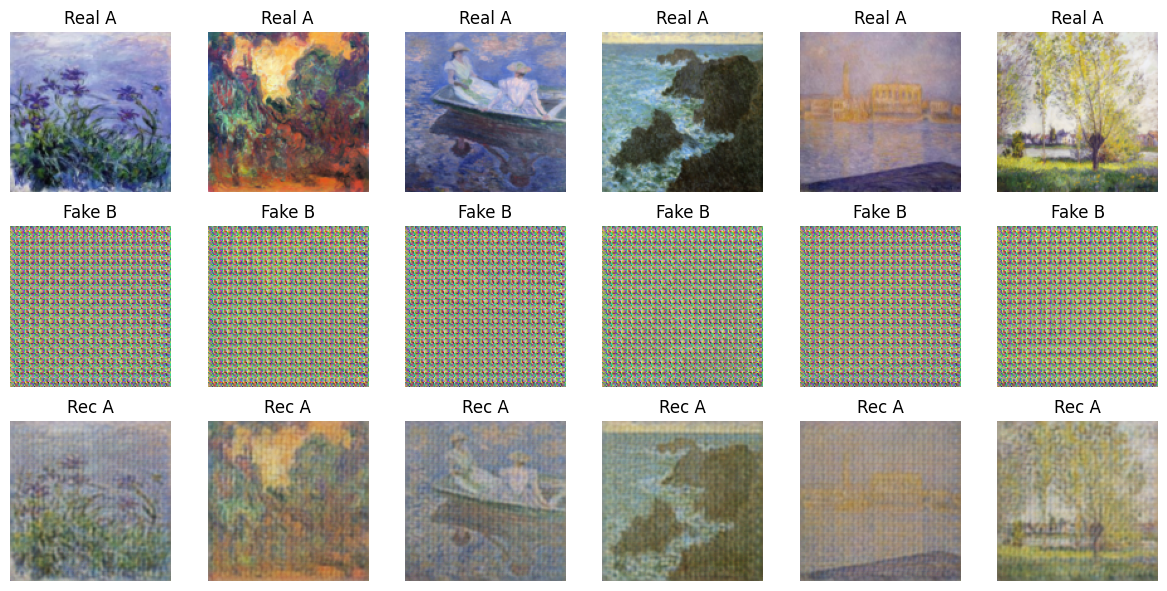

In [ ]:
# Example usage
show_converted_images(G_A2B, G_B2A, train_loader_A)

the reconstructed images appear slightly clearer and more coherent compared to the previous results, indicating that the cycle-consistency loss might be working better after the adjustments.

 4. load your favorite image (or your picture) apply Cyclegan and upload it with the report.

In [ ]:
from PIL import Image

In [ ]:
# Loading the uploaded image
img_path = "img.jpeg"  # Use the path of the uploaded image
img = Image.open(img_path)

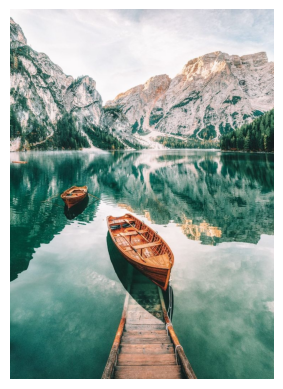

In [ ]:
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
# Defining image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match the model input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [ ]:
# Preprocess the image
img_tensor = transform(img).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

In [ ]:
# Applying the trained CycleGAN models
with torch.no_grad():
    fake_B = G_A2B(img_tensor)  # Translate from domain A to B
    rec_A = G_B2A(fake_B)  # Reconstruct back to domain A


In [ ]:
#  convert tensor to image
def tensor_to_image(tensor):
    image = tensor.cpu().clone().detach()  # Move to CPU
    image = image.squeeze(0)  # Remove batch dimension
    image = (image + 1) / 2  # Unnormalize from [-1, 1] to [0, 1]
    return transforms.ToPILImage()(image)

In [ ]:
# Converting the generated images
translated_img = tensor_to_image(fake_B)
reconstructed_img = tensor_to_image(rec_A)

In [ ]:
# Display the results
translated_img.show(title="Translated Image (Domain B)")
reconstructed_img.show(title="Reconstructed Image (Domain A)")

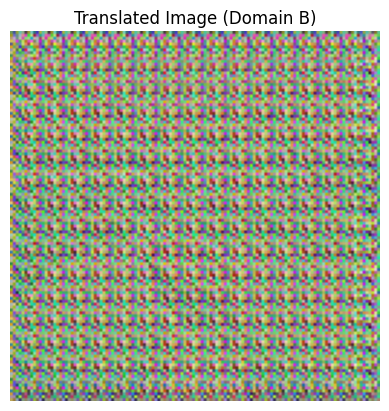

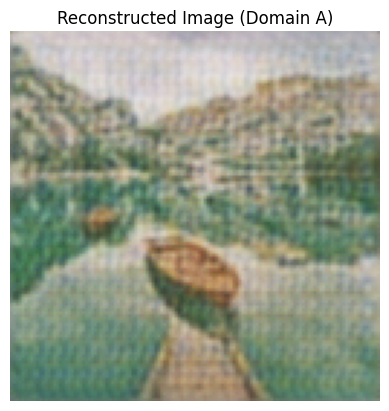

In [ ]:
# Display the translated image (Domain B)
plt.imshow(translated_img)
plt.axis('off')  # Hide axes
plt.title("Translated Image (Domain B)")
plt.show()

# Display the reconstructed image (Domain A)
plt.imshow(reconstructed_img)
plt.axis('off')  # Hide axes
plt.title("Reconstructed Image (Domain A)")
plt.show()

The CycleGAN model doesn’t seem to have clear images but rather blurry images indicating that while the model has learned some general aspects, it does have problems with high level details. So in this case it can be said that the model's cycle-consistency mechanism is somewhat functional although the generators seem to have learning the mappers between domain A and domain B.

 DCGAN Implementation

In [ ]:
# Loading a dataset
train_dataset = dsets.CIFAR10(root='./data', download=True, transform=transform)

# Create DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)


100%|██████████| 170498071/170498071 [00:13<00:00, 13015153.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [10]:
# Generator architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is a latent vector Z
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [12]:
# Creating the models
netG = Generator().cuda()
netD = Discriminator().cuda()

In [18]:
# Loss function
criterion = nn.BCELoss()

In [ ]:
# Creating the optimizers
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [16]:
# Training parameters
num_epochs = 25
real_label = 1
fake_label = 0

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update Discriminator
        ############################
        netD.zero_grad()

        # Train with real images
        real_images, _ = data
        real_images = real_images.cuda()
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float).cuda()

        output = netD(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()

        # Train with fake images
        noise = torch.randn(batch_size, 100, 1, 1).cuda()
        fake_images = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()

        optimizerD.step()

        ############################
        # (2) Update Generator
        ############################
        netG.zero_grad()
        labels.fill_(real_label)  # Real labels for generator loss
        output = netD(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}], Loss D: {lossD_real.item() + lossD_fake.item()}, Loss G: {lossG.item()}")

Epoch [0/25], Step [0], Loss D: 1.3187726736068726, Loss G: 3.850583553314209
Epoch [0/25], Step [100], Loss D: 0.6354447305202484, Loss G: 2.0878307819366455
Epoch [0/25], Step [200], Loss D: 0.3742154538631439, Loss G: 3.8190009593963623
Epoch [0/25], Step [300], Loss D: 0.12800734117627144, Loss G: 3.8237953186035156
Epoch [1/25], Step [0], Loss D: 0.653142973780632, Loss G: 2.965264320373535
Epoch [1/25], Step [100], Loss D: 1.0531602799892426, Loss G: 1.7244997024536133
Epoch [1/25], Step [200], Loss D: 0.663049966096878, Loss G: 4.113414764404297
Epoch [1/25], Step [300], Loss D: 0.6682088822126389, Loss G: 3.9139297008514404
Epoch [2/25], Step [0], Loss D: 1.1587564013898373, Loss G: 7.216132640838623
Epoch [2/25], Step [100], Loss D: 0.2836170941591263, Loss G: 2.644925117492676
Epoch [2/25], Step [200], Loss D: 0.6465919315814972, Loss G: 2.9775986671447754
Epoch [2/25], Step [300], Loss D: 0.536242350935936, Loss G: 2.658242702484131
Epoch [3/25], Step [0], Loss D: 0.44777058

Experimentation

Change Latent Vector Size:



In [ ]:
latent_dim = 50  # Experiment with different latent space sizes
noise = torch.randn(batch_size, latent_dim, 1, 1).cuda()


Adjust Learning Rate:

In [ ]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))  # Lower learning rate for better stability
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))


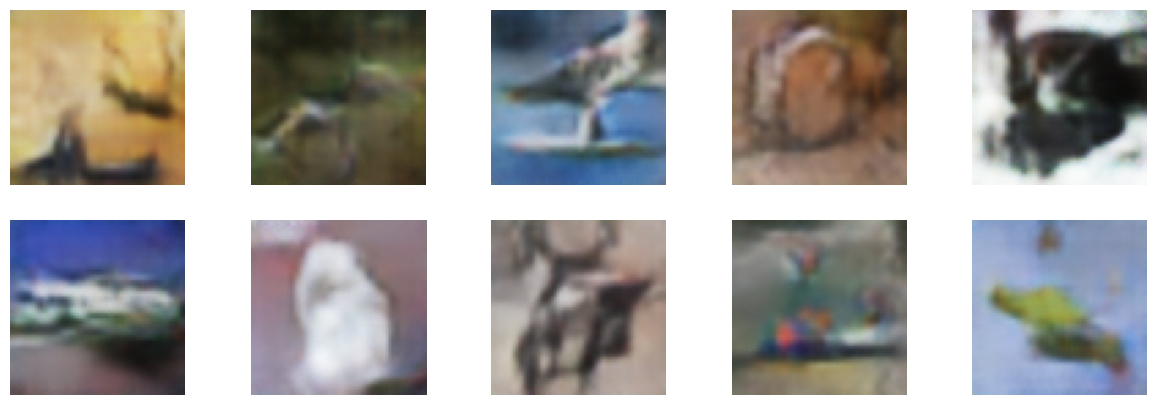

In [ ]:
import matplotlib.pyplot as plt

# Visualize the generated images
def show_generated_images(generator, num_images=10):
    generator.eval()
    noise = torch.randn(num_images, 100, 1, 1).cuda()
    fake_images = generator(noise)

    # Convert to CPU and show images
    fake_images = fake_images.cpu().detach().numpy().transpose(0, 2, 3, 1)  # Convert to HWC
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow((fake_images[i] + 1) / 2)  # Denormalize to [0, 1]
        plt.axis('off')
    plt.show()

# Call this function after a few epochs of training
show_generated_images(netG)


Findings

This is because of insufficient training. DCGANs usually require a significant number of epochs to learn meaningful patterns from the data.

the learning rate is too high, the model may not converge well, resulting in unstable and poor-quality generated images.

In [3]:
# Defineing everything because the runtime ended

In [1]:
import torchvision.datasets as dsets

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resizing the images to 64x64 for DCGAN
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] as DCGAN expects this
])

In [5]:
# Loading a dataset
train_dataset = dsets.CIFAR10(root='./data', download=True, transform=transform)

# Create DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 34441630.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [13]:
# Using a smaller learning rate
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))


In [14]:
# Adding additional layer

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a transposed convolution
            nn.ConvTranspose2d(100, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [19]:
# Increase the number of epochs
num_epochs = 50  # Increase to 100 epochs or more

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update Discriminator
        ############################
        netD.zero_grad()

        # Train with real images
        real_images, _ = data
        real_images = real_images.cuda()
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float).cuda()

        output = netD(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()

        # Train with fake images
        noise = torch.randn(batch_size, 100, 1, 1).cuda()
        fake_images = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()

        optimizerD.step()

        ############################
        # (2) Update Generator
        ############################
        netG.zero_grad()
        labels.fill_(real_label)  # Real labels for generator loss
        output = netD(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}], Loss D: {lossD_real.item() + lossD_fake.item()}, Loss G: {lossG.item()}")

Epoch [0/50], Step [0], Loss D: 1.3801433444023132, Loss G: 1.967540979385376
Epoch [0/50], Step [50], Loss D: 0.04189459793269634, Loss G: 7.396899700164795
Epoch [0/50], Step [100], Loss D: 0.021371030248701572, Loss G: 7.444950103759766
Epoch [0/50], Step [150], Loss D: 0.012011499144136906, Loss G: 7.062739849090576
Epoch [0/50], Step [200], Loss D: 0.009552260162308812, Loss G: 7.141856670379639
Epoch [0/50], Step [250], Loss D: 0.9515417756393845, Loss G: 6.9637837409973145
Epoch [0/50], Step [300], Loss D: 0.1419801265001297, Loss G: 7.545846939086914
Epoch [0/50], Step [350], Loss D: 0.1005074754357338, Loss G: 5.030976295471191
Epoch [1/50], Step [0], Loss D: 0.3109515644609928, Loss G: 10.61788272857666
Epoch [1/50], Step [50], Loss D: 0.1750524863600731, Loss G: 3.878239631652832
Epoch [1/50], Step [100], Loss D: 0.22203359007835388, Loss G: 3.5099434852600098
Epoch [1/50], Step [150], Loss D: 0.1910069091245532, Loss G: 5.489130973815918
Epoch [1/50], Step [200], Loss D: 0.

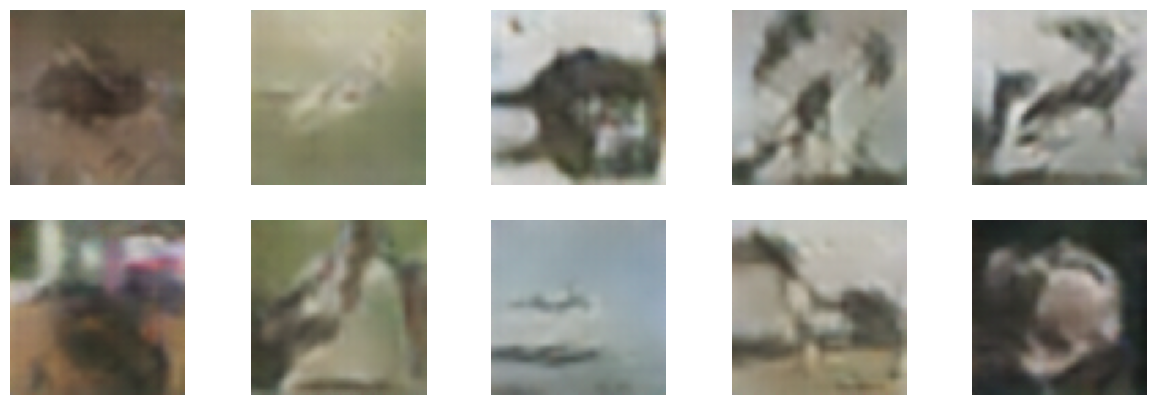

In [20]:
import matplotlib.pyplot as plt

# Visualize the generated images
def show_generated_images(generator, num_images=10):
    generator.eval()  # Set generator to eval mode
    noise = torch.randn(num_images, 100, 1, 1).cuda()
    fake_images = generator(noise)

    # Convert to CPU and show images
    fake_images = fake_images.cpu().detach().numpy().transpose(0, 2, 3, 1)  # Convert to HWC
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow((fake_images[i] + 1) / 2)  # Denormalize to [0, 1]
        plt.axis('off')
    plt.show()

# Example usage: Call this after a few epochs of training
show_generated_images(netG)


The images are slightly better compared to the previous output, 25 and 50 epochs do not make any huge difference, and 100 or 200 would give a better result  
